In [105]:
import os
import numpy as np
import pandas as pd
from scipy import signal, stats
from scipy.signal import butter, medfilt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

def butter_highpass_filter(ecg, cutoff, Fs, order):
    nyq = 0.5 * Fs
    normal_cutoff = cutoff / nyq
    
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, ecg)
    return y

def butter_bandstop_filter(ecg, low, high, Fs, order):
    nyq = 0.5 * Fs
    low = low/ nyq
    high = high/ nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    y = signal.filtfilt(b,a,ecg)
    return y

def butter_lowpass_filter(ecg, cutoff, Fs, order):
    nyq = 0.5 * Fs
    normal_cutoff = cutoff / nyq
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, ecg)
    return y

def denoise_ecg(amuse_signal, normal_signal, stress_signal, high, low, sampling_rate, order):
    # high pass filter (0.5)
    bw_amuse = butter_highpass_filter(amuse_signal, high, sampling_rate, order)
    bw_normal = butter_highpass_filter(normal_signal, high, sampling_rate, order)
    bw_stress = butter_highpass_filter(stress_signal, high, sampling_rate, order)

    # notch filter (57,63) - 50 Hz noise 제거
    notch_amuse = butter_bandstop_filter(bw_amuse, 57, 63, sampling_rate, order)
    notch_normal = butter_bandstop_filter(bw_normal, 57, 63, sampling_rate, order)
    notch_stress = butter_bandstop_filter(bw_stress, 57, 63, sampling_rate, order)

    # notch filter (47, 53) - 60 Hz noise 제거 
    notch_amuse = butter_bandstop_filter(notch_amuse, 47, 53, sampling_rate, order)
    notch_normal = butter_bandstop_filter(notch_normal, 47, 53, sampling_rate, order)
    notch_stress = butter_bandstop_filter(notch_stress, 47, 53, sampling_rate, order)

    # low pass filter
    low_amuse = butter_lowpass_filter(notch_amuse, low, sampling_rate, order)
    low_normal = butter_lowpass_filter(notch_normal, low, sampling_rate, order)
    low_stress = butter_lowpass_filter(notch_stress, low, sampling_rate, order)
    
    return low_amuse, low_normal, low_stress

def Delet_outlier(data, high_level = None, low_level = None):
    
    high = False if high_level is None else high_level
    low = False if low_level is None else low_level
    
    ex_data = pd.Series(data)
    Q1 = ex_data.quantile(0.25)
    Q3 = ex_data.quantile(0.75)
    IQR = Q3 - Q1 
    
    if high and low:
        dff = ex_data[(ex_data <= Q3+(high*IQR)) & (ex_data >= Q1-(low*IQR))]
        
    elif high and not low:
        dff = ex_data[(ex_data <=Q3+(high*IQR))]
        
    elif not high and low:
        dff = ex_data[(ex_data >= Q1-(low*IQR))]
    else :
        dff = ex_data
    
    #dff = ex_data[(ex_data <= Q3+(high_level*IQR)) & (ex_data >= Q1-(low_level*IQR))]
    
    dff = dff.reset_index(drop=True)
    
    return np.array(dff)

def minmax(data):
    scaler = MinMaxScaler()
    new = scaler.fit_transform(data.reshape(-1,1))
    return new


def plot_ecg(amuse, normal, stress):
    plt.figure(figsize=(20,3))
    plt.subplot(1,3,1)
    plt.plot(amuse); plt.title('Amuse')
    plt.subplot(1,3,2)
    plt.plot(normal); plt.title('Normal')
    plt.subplot(1,3,3)
    plt.plot(stress); plt.title('Stress')
    plt.show()

In [104]:
for i in range(10):
    if i < 5 :
        print(i)
    elif i < 9:
        print(i)

0
1
2
3
4
5
6
7
8


### 잡음제거, 정규화, 전처리

-초기설정

In [2]:
# Initial settings
Data = "D:/Database/WESAD/"
save_path = 'D:/ICMLA/Database/'
sampling_rate = 700
random_state = 42


# rhythm
window = 5 * 700 # 5초 3,500 data point
overlap = 2 * 700 # 2초 중첩 1,400 data point 


# preprocessing
high_cutoff = 0.5
sampling_rate = 700
ts = 1 / sampling_rate
nyq = 0.5 * sampling_rate # 나이퀴스트 
order = 2
low_cutoff = 100

# segmentation
a_low = [-0.45, -0.55, -0.55, -1, -0.5, -1, -0.7, -1, -0.8, -0.9, -0.7, -1.3, -0.7, -0.7, -0.8]
a_high = [0.85, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.5, 1.2, 1.6, 1.5, 1.7, 1.6, 1.6, 1.6] 
subjects = np.array(['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17'])

# k-fold settings
n_split = 5 # num of Fold
accuracies = [] # Fold accuracy list
fold_i = 0



In [5]:
# 잡음제거 -> baseline wander, power line interfernece
# 기준선 잡음 제거(gw pass filter)
# 전력선 잡음 제거 (pp
# 이상치 제거 
# 정규화 

df = pd.read_pickle(Data + 'S2' + '/' + 'S2' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

# high pass filter (0.5)
bw_amuse = butter_highpass_filter(amuse_ecg, high_cutoff, sampling_rate, order)
bw_normal = butter_highpass_filter(normal_ecg, high_cutoff, sampling_rate, order)
bw_stress = butter_highpass_filter(stress_ecg, high_cutoff, sampling_rate, order)

# notch filter (57,63)
notch_amuse = butter_bandstop_filter(bw_amuse, 57, 63, sampling_rate, order)
notch_normal = butter_bandstop_filter(bw_normal, 57, 63, sampling_rate, order)
notch_stress = butter_bandstop_filter(bw_stress, 57, 63, sampling_rate, order)

# notch filter (47, 53)
notch_amuse = butter_bandstop_filter(notch_amuse, 47, 53, sampling_rate, order)
notch_normal = butter_bandstop_filter(notch_normal, 47, 53, sampling_rate, order)
notch_stress = butter_bandstop_filter(notch_stress, 47, 53, sampling_rate, order)

# low pass filter
low_amuse = butter_lowpass_filter(notch_amuse, low_cutoff, sampling_rate, order)
low_normal = butter_lowpass_filter(notch_normal, low_cutoff, sampling_rate, order)
low_stress = butter_lowpass_filter(notch_stress, low_cutoff, sampling_rate, order)

# 이상치 제거 

#  S2 - amuse와 stress는 큰 값이 없음(그대로)

In [93]:
df = pd.read_pickle(Data + 'S2' + '/' + 'S2' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

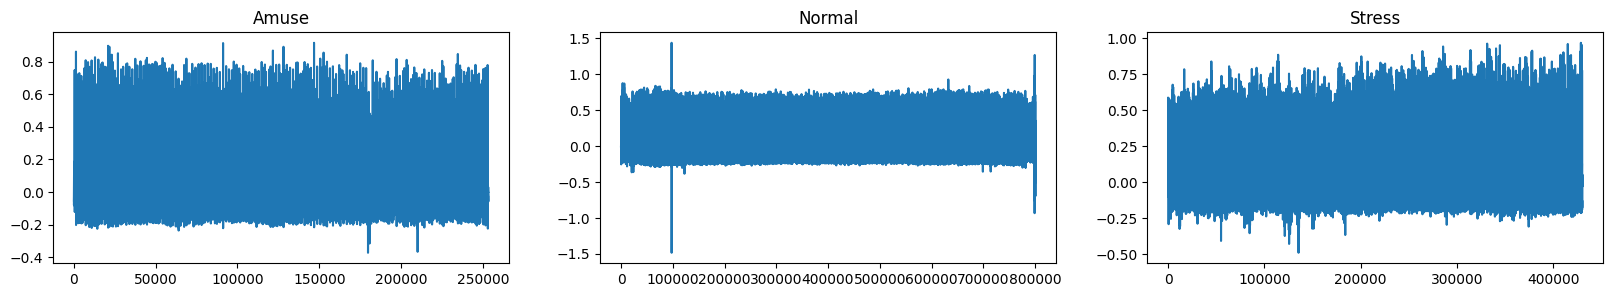

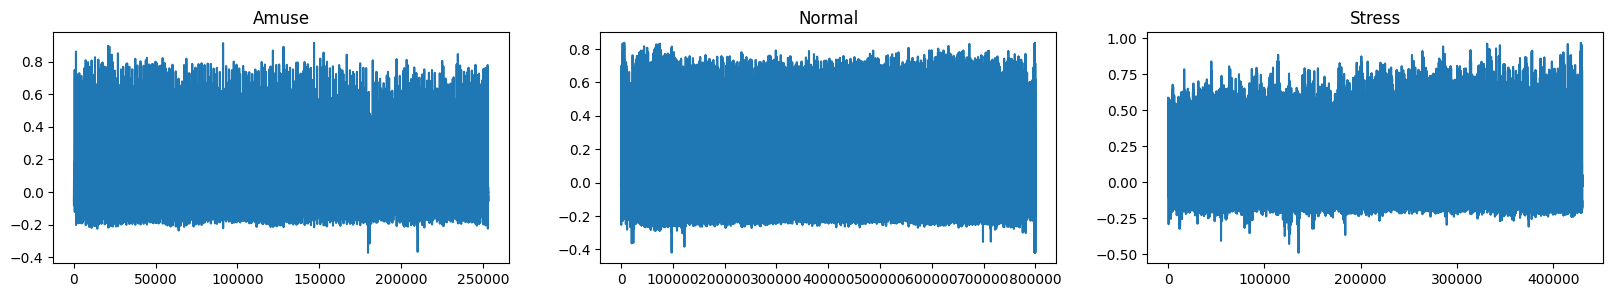

In [94]:
amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)


#out_amuse = Delet_outlier(amuse_n,3,3)
out_normal = Delet_outlier(normal_n, 5, 2)
#out_stress = Delet_outlier(stress_n,3,3)

plot_ecg(amuse_n, out_normal, stress_n)

### S2 정규화

(241823, 1) (800246, 1) (415409, 1)


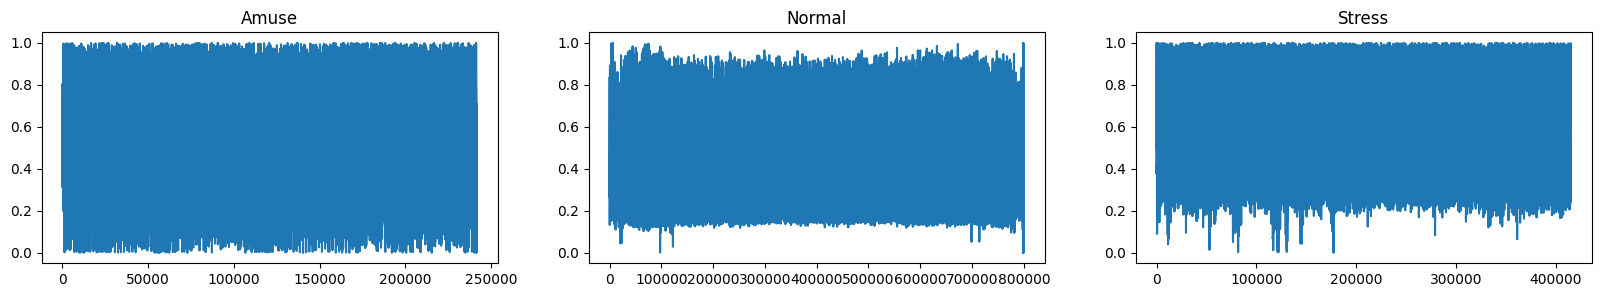

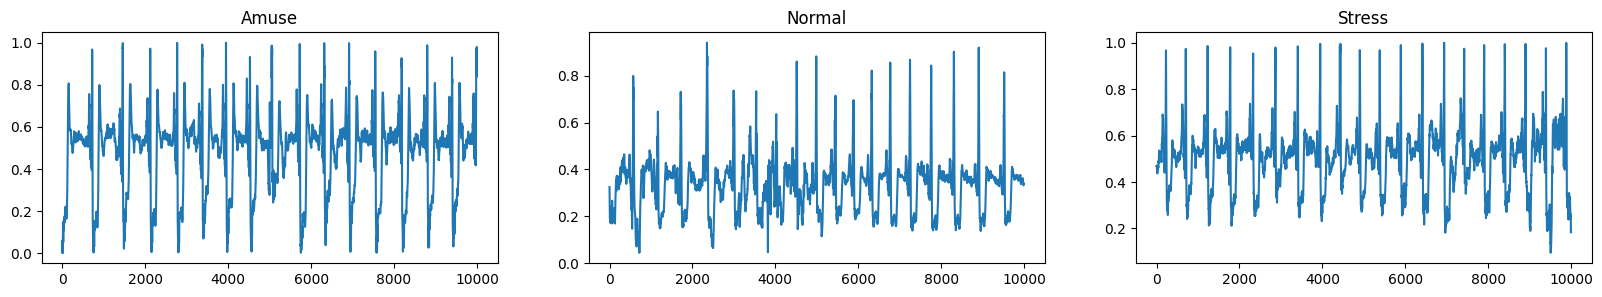

In [95]:
amuse = minmax(out_amuse)
normal = minmax(out_normal)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [96]:
new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

S2_data = {"signal" : new_data, "label" : new_label}

with open(save_path + 'S2.pkl','wb') as fw:
    pickle.dump(S2_data, fw)

#  S3

In [97]:
df = pd.read_pickle(Data + 'S3' + '/' + 'S3' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

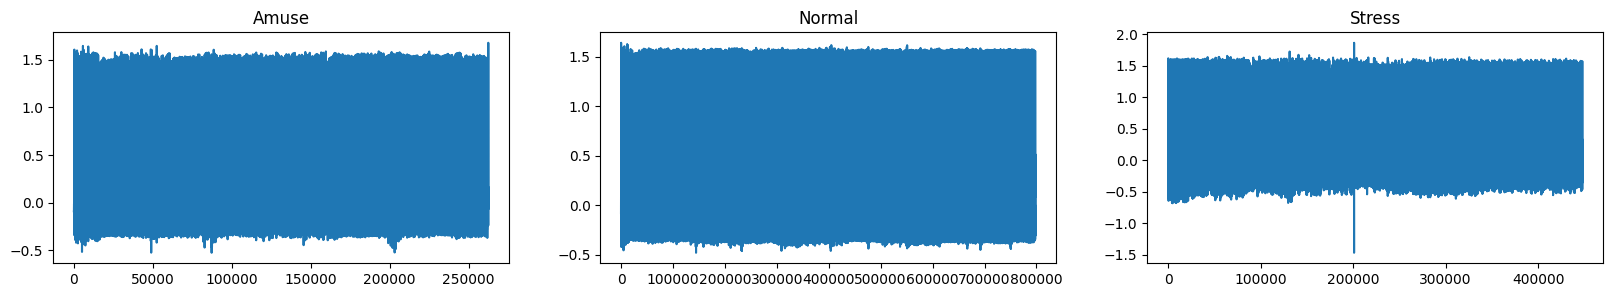

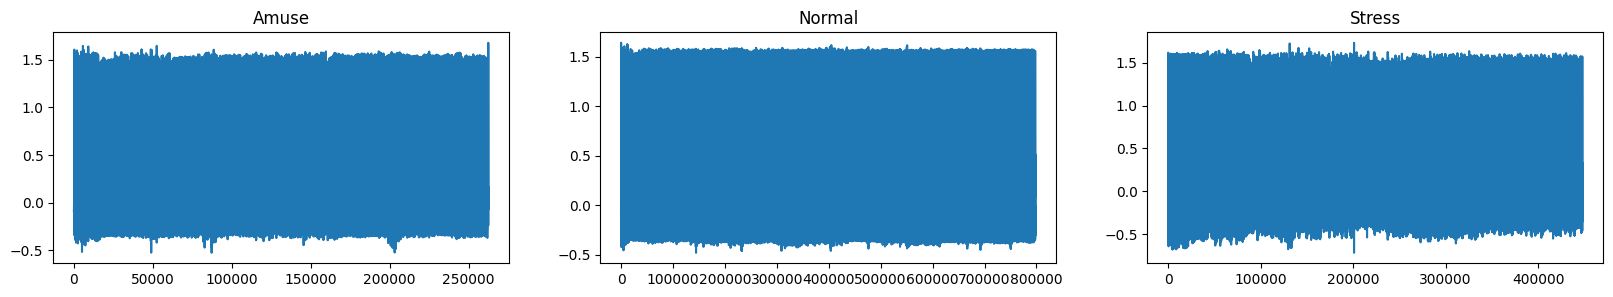

In [117]:
amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

out_stress = Delet_outlier(stress_n, 11, 4)

plot_ecg(amuse_n, normal_n, out_stress)

(262500, 1) (798000, 1) (447914, 1)


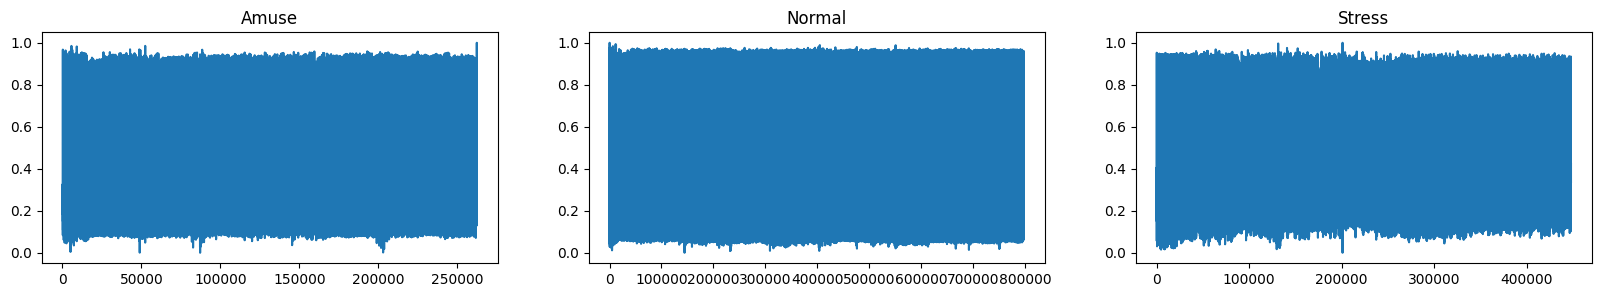

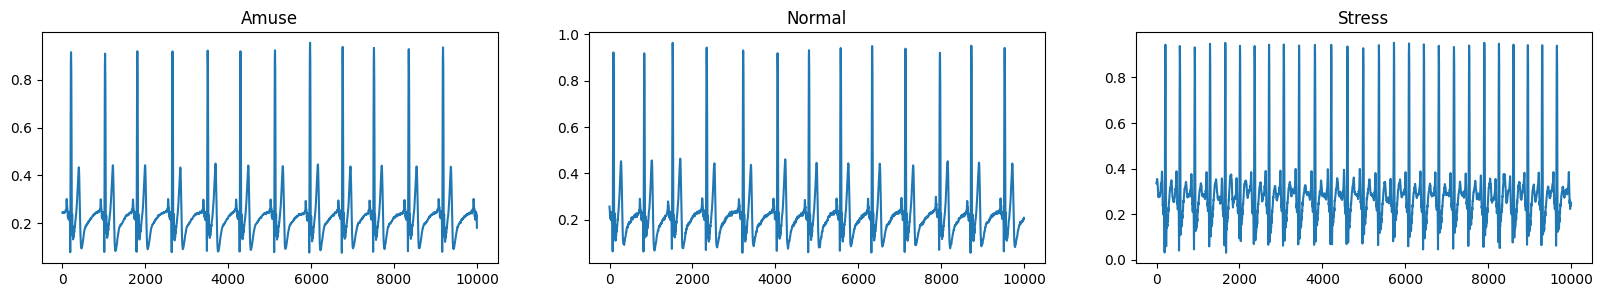

In [118]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [123]:
name = 'S3'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

#  S4

In [124]:
df = pd.read_pickle(Data + 'S4' + '/' + 'S4' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

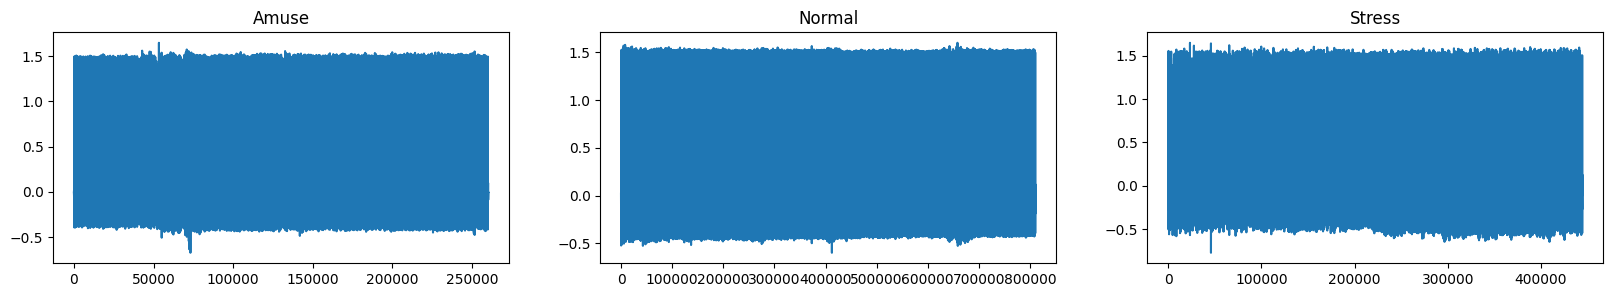

In [126]:
amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

#out_stress = Delet_outlier(stress_n, 11, 4)
#plot_ecg(amuse_n, normal_n, out_stress)

(260400, 1) (810601, 1) (444500, 1)


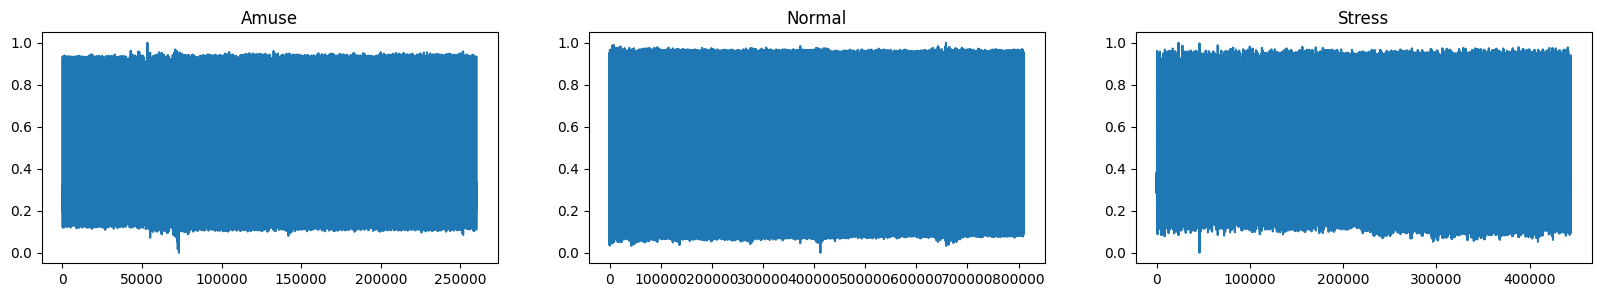

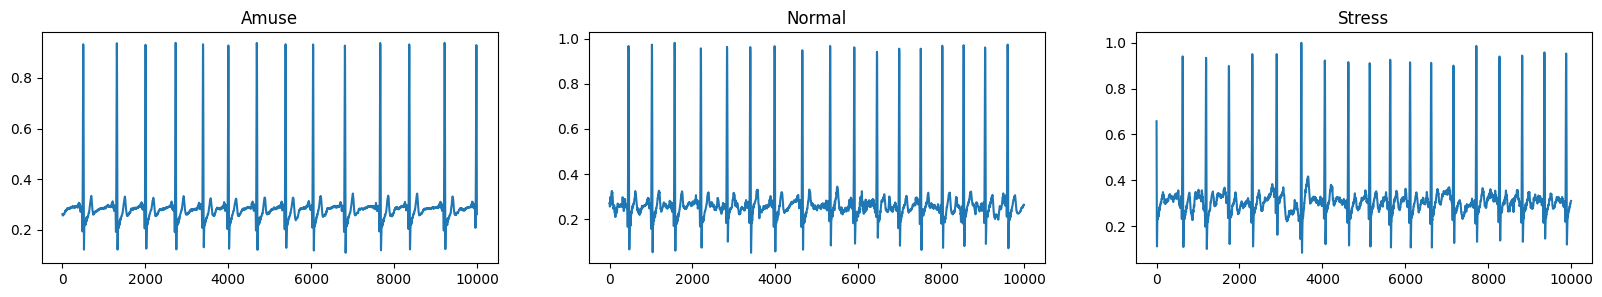

In [127]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [129]:
name = 'S4'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

#  S5

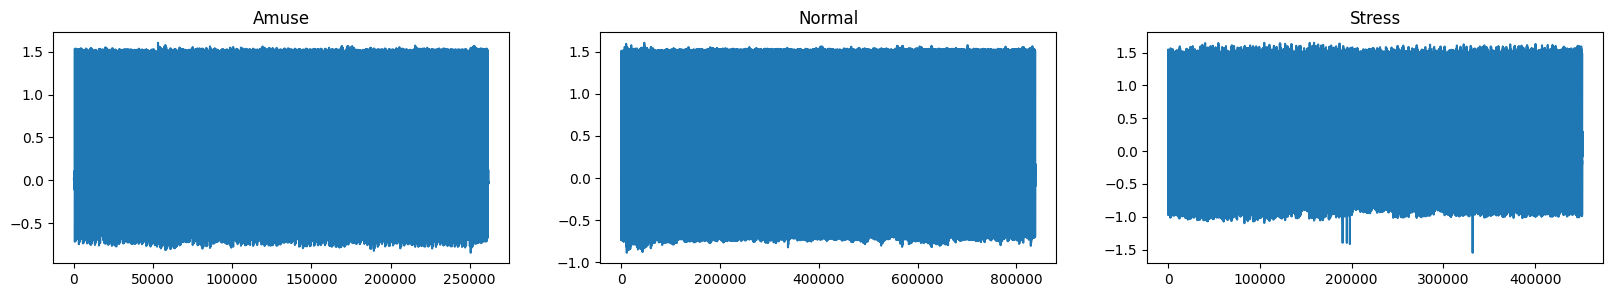

In [130]:
df = pd.read_pickle(Data + 'S5' + '/' + 'S5' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

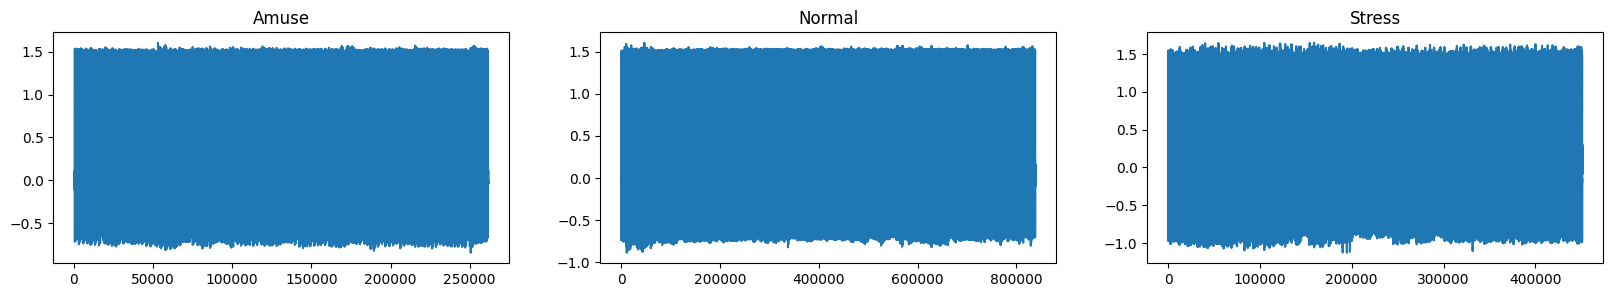

In [133]:
out_stress = Delet_outlier(stress_n, None, 9)
plot_ecg(amuse_n, normal_n, out_stress)

(261800, 1) (838600, 1) (451334, 1)


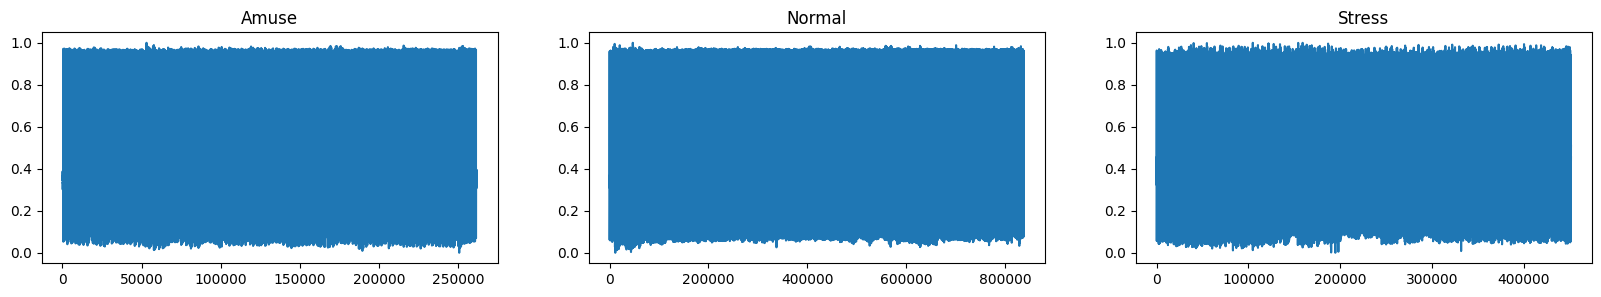

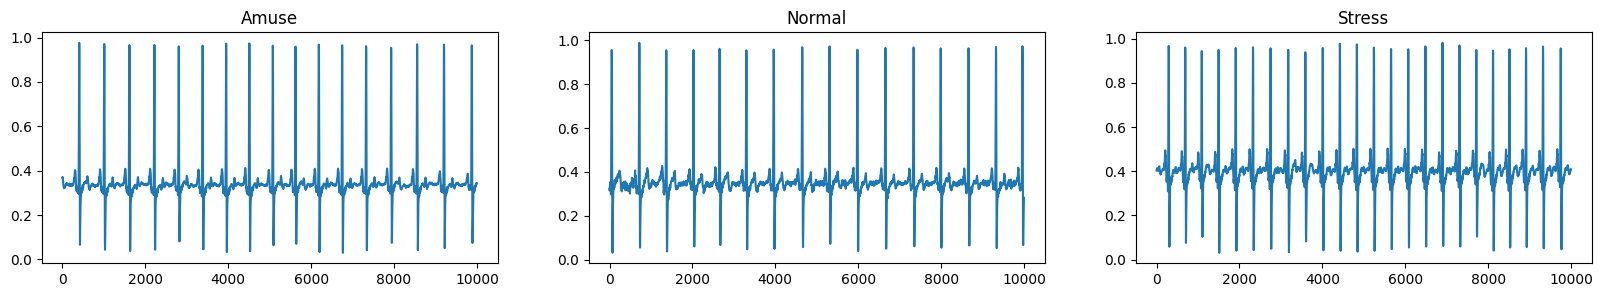

In [134]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [135]:
name = 'S5'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

#  S6

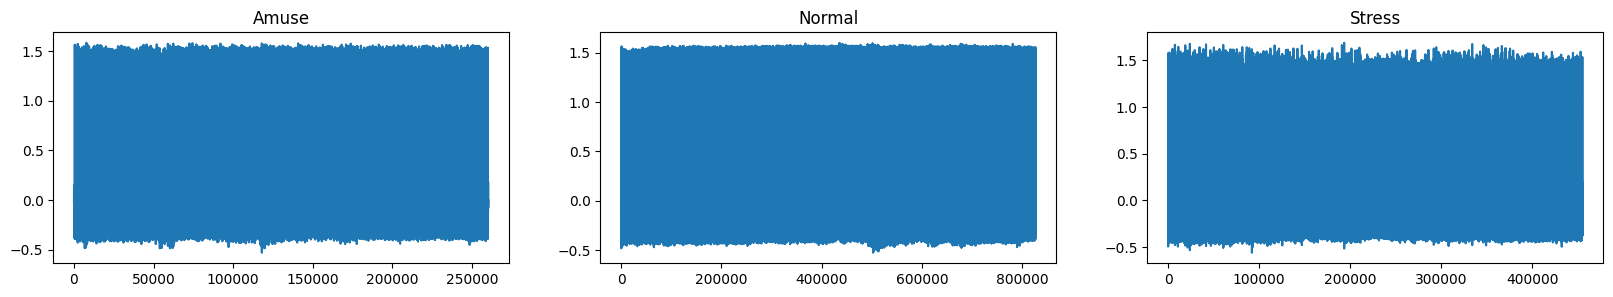

In [136]:
df = pd.read_pickle(Data + 'S6' + '/' + 'S6' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

(260400, 1) (826000, 1) (455000, 1)


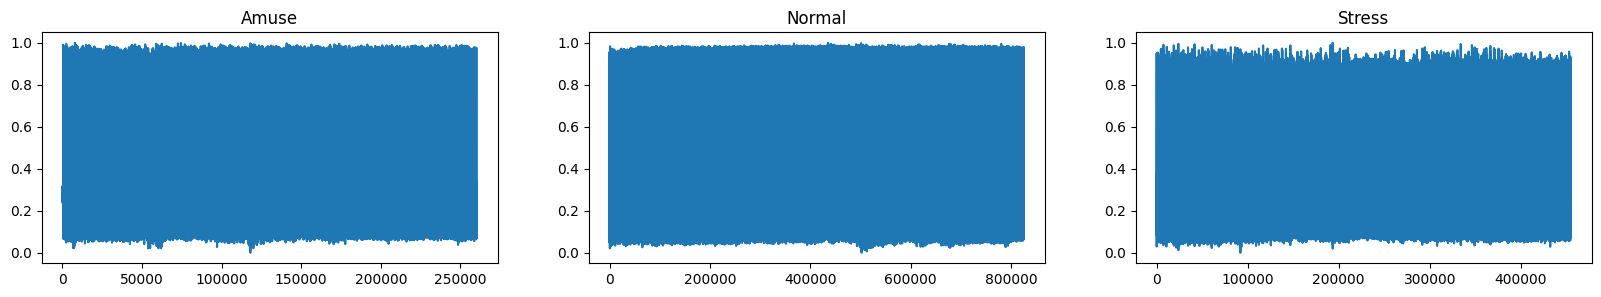

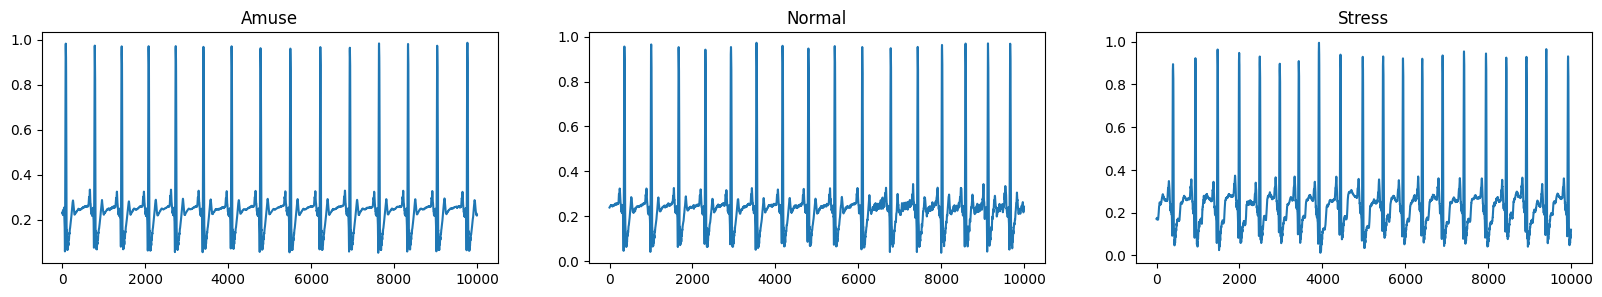

In [137]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [140]:
name = 'S6'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

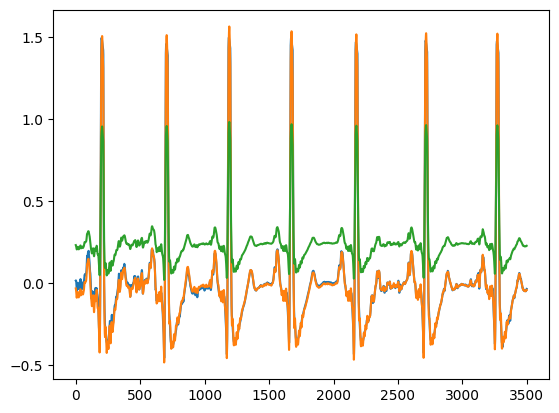

In [139]:
plt.plot(normal_ecg[0:3500])
plt.plot(normal_n[0:3500])
plt.plot(normal[0:3500])

#  S7

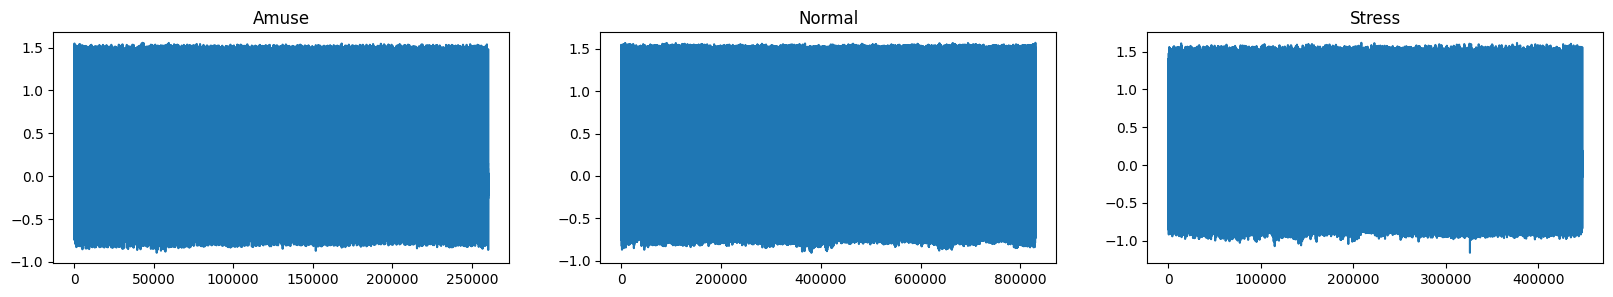

In [141]:
df = pd.read_pickle(Data + 'S7' + '/' + 'S7' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

(260401, 1) (830200, 1) (448000, 1)


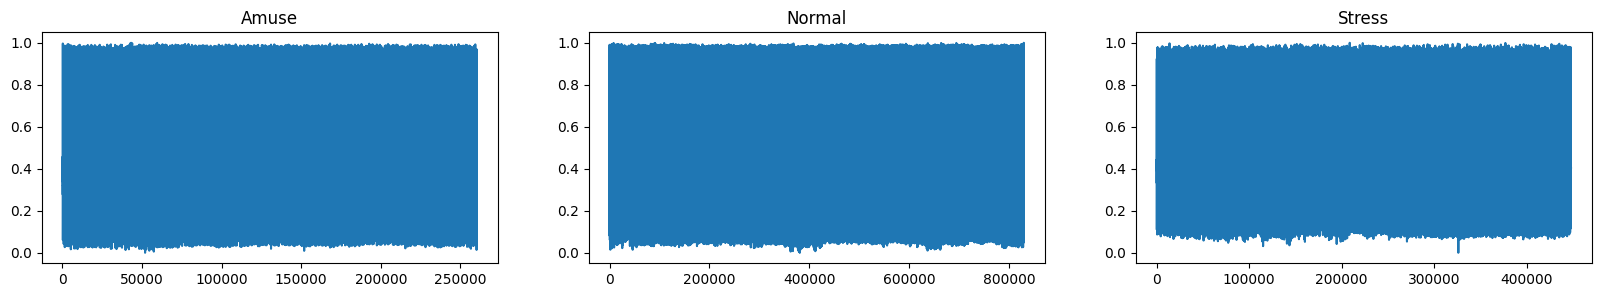

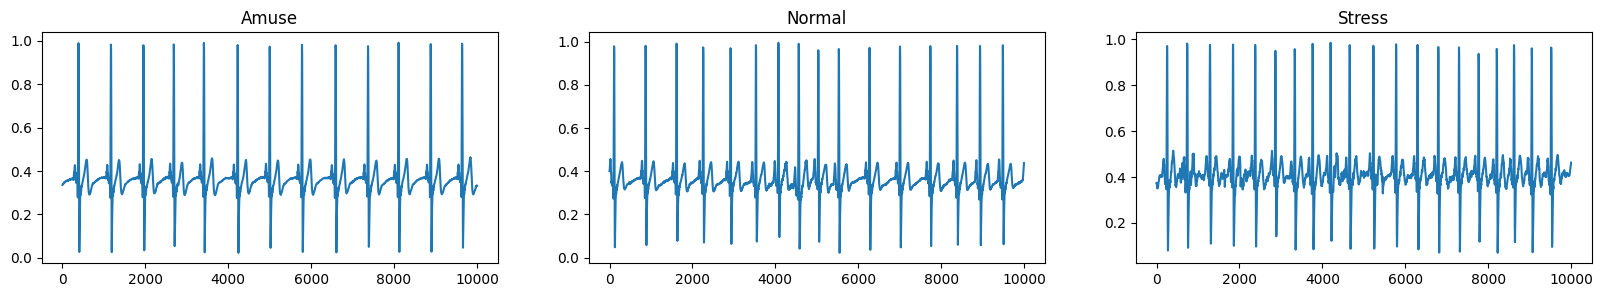

In [142]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [143]:
name = 'S7'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

#  S8

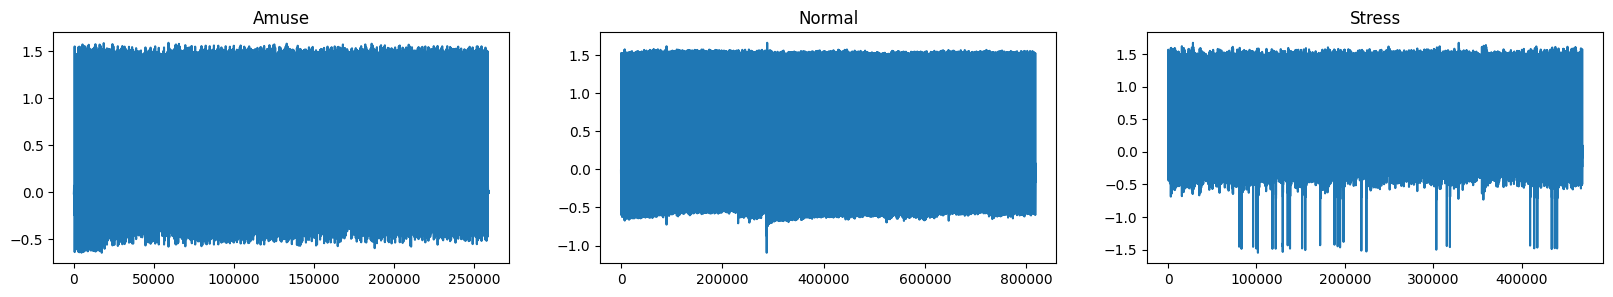

In [144]:
df = pd.read_pickle(Data + 'S8' + '/' + 'S8' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

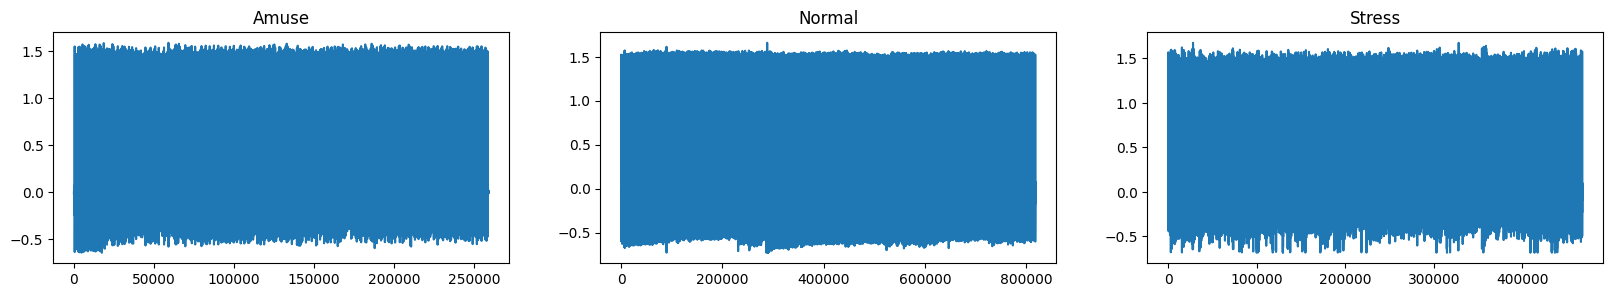

In [160]:
out_normal = Delet_outlier(normal_n, None, 14)
out_stress = Delet_outlier(stress_n, None, 2.5)

plot_ecg(amuse_n, out_normal, out_stress)

(258999, 1) (818281, 1) (467761, 1)


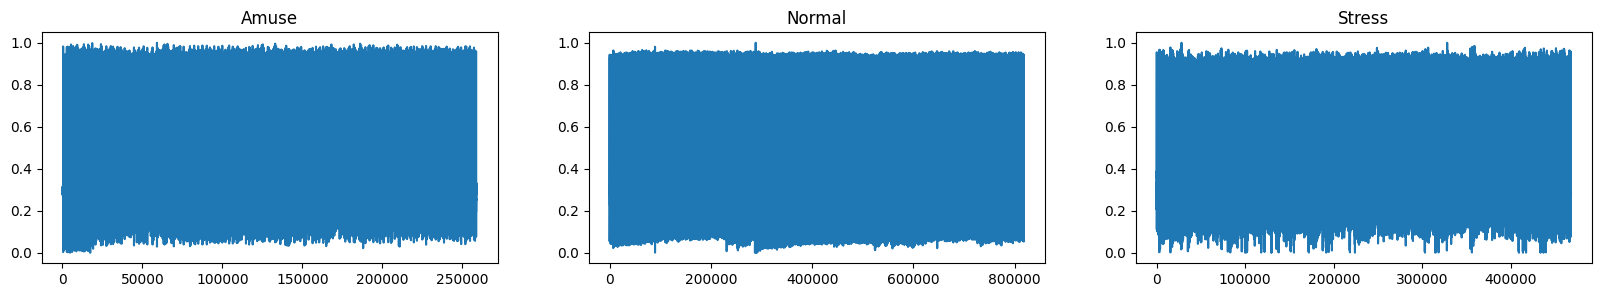

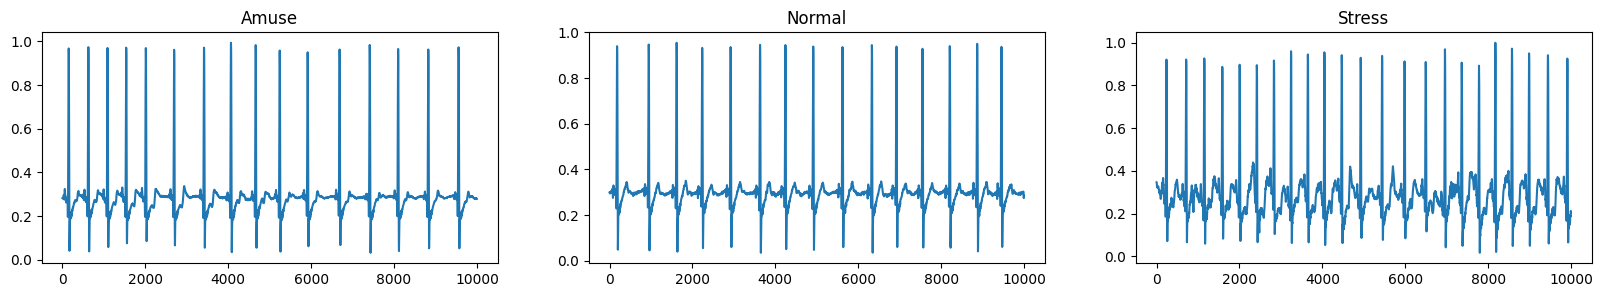

In [161]:
amuse = minmax(amuse_n)
normal = minmax(out_normal)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [162]:
name = 'S8'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S9

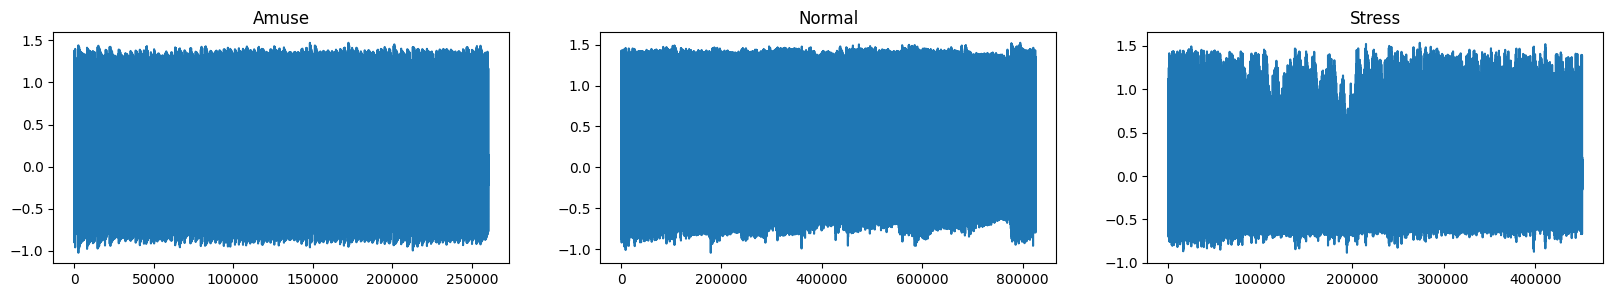

In [167]:
df = pd.read_pickle(Data + 'S9' + '/' + 'S9' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

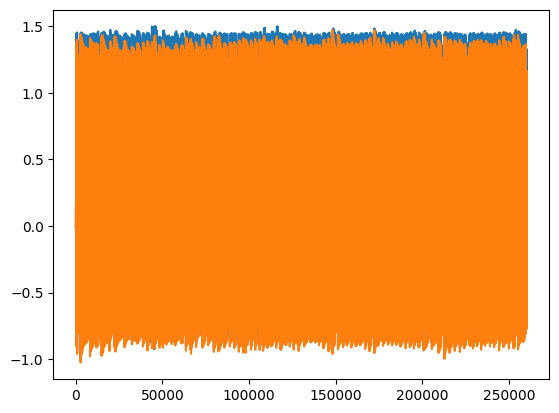

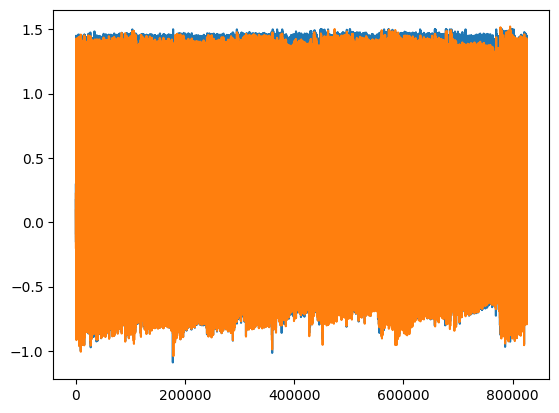

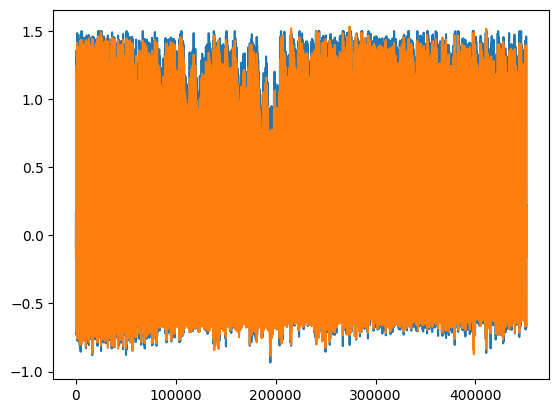

In [166]:
plt.plot(amuse_ecg)
plt.plot(amuse_n)
plt.show()
plt.plot(normal_ecg)
plt.plot(normal_n)
plt.show()
plt.plot(stress_ecg)
plt.plot(stress_n)

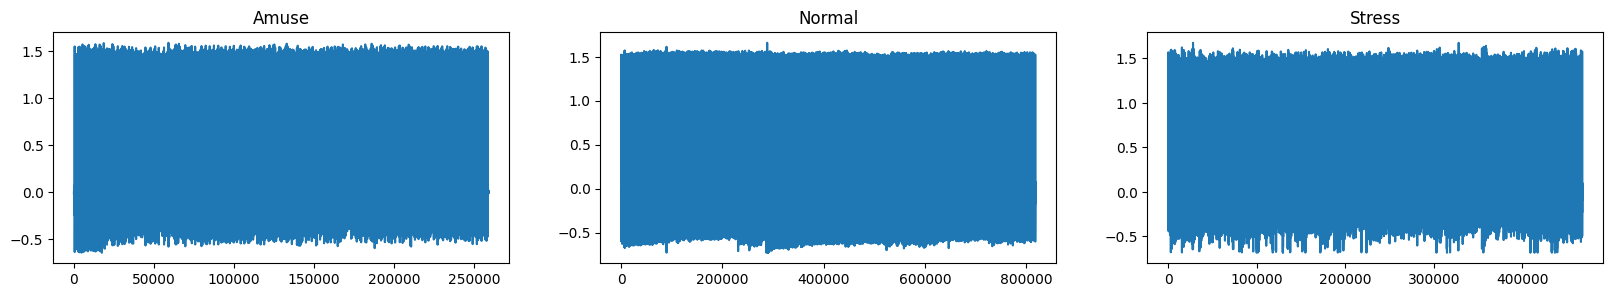

In [160]:
#out_normal = Delet_outlier(normal_n, None, 14)
#out_stress = Delet_outlier(stress_n, None, 2.5)

#plot_ecg(amuse_n, out_normal, out_stress)

(260400, 1) (826000, 1) (451500, 1)


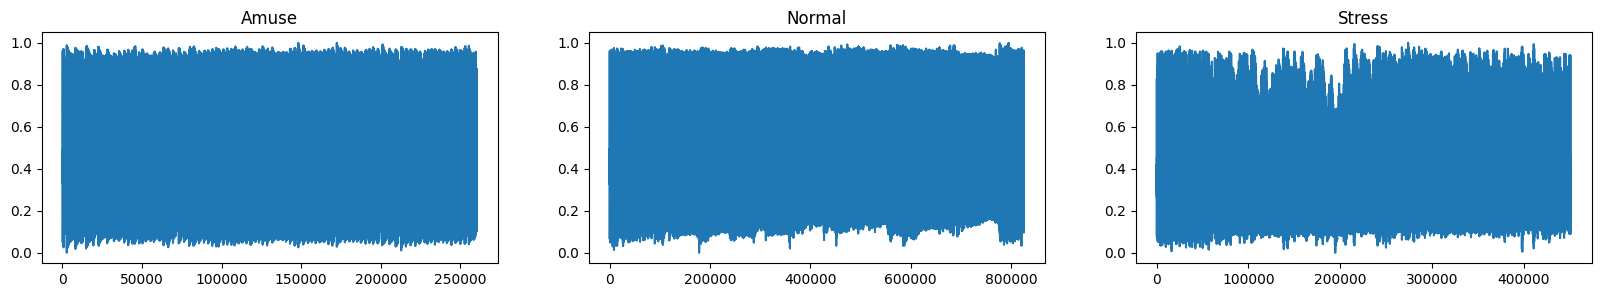

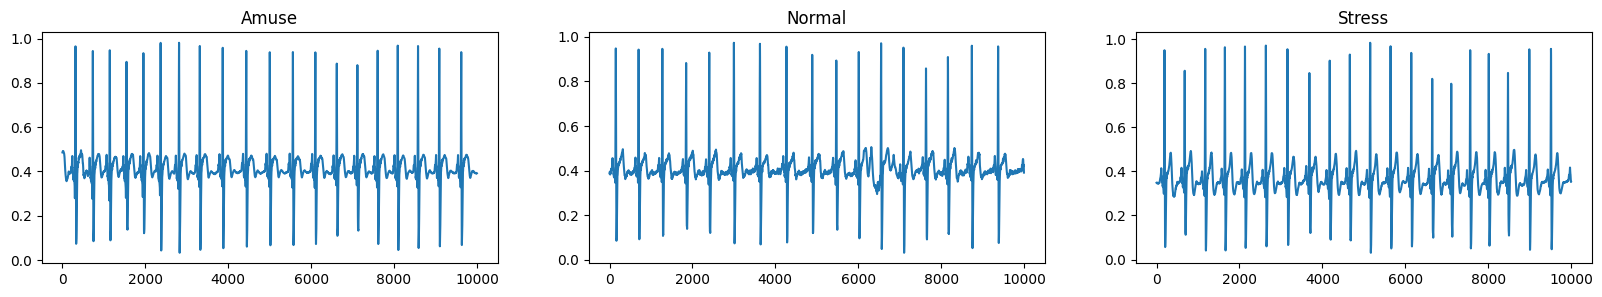

In [168]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [169]:
name = 'S9'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S10

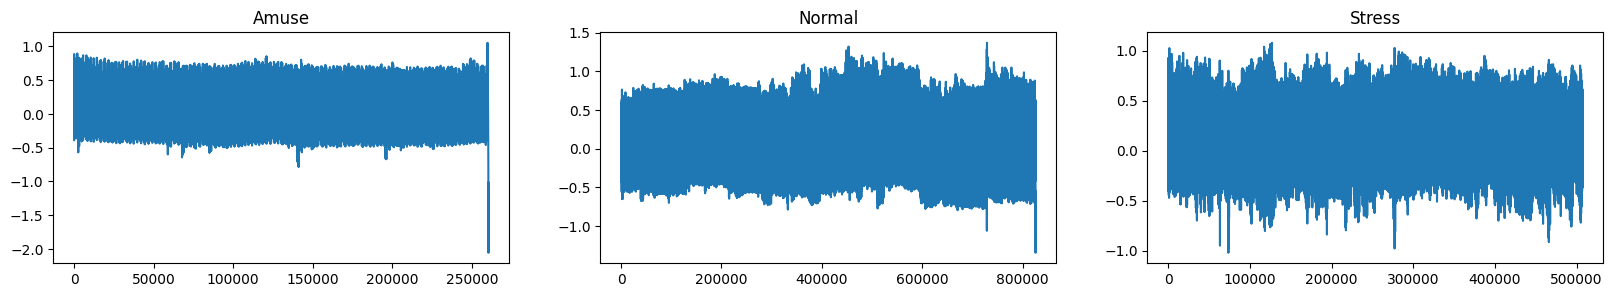

In [170]:
df = pd.read_pickle(Data + 'S10' + '/' + 'S10' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

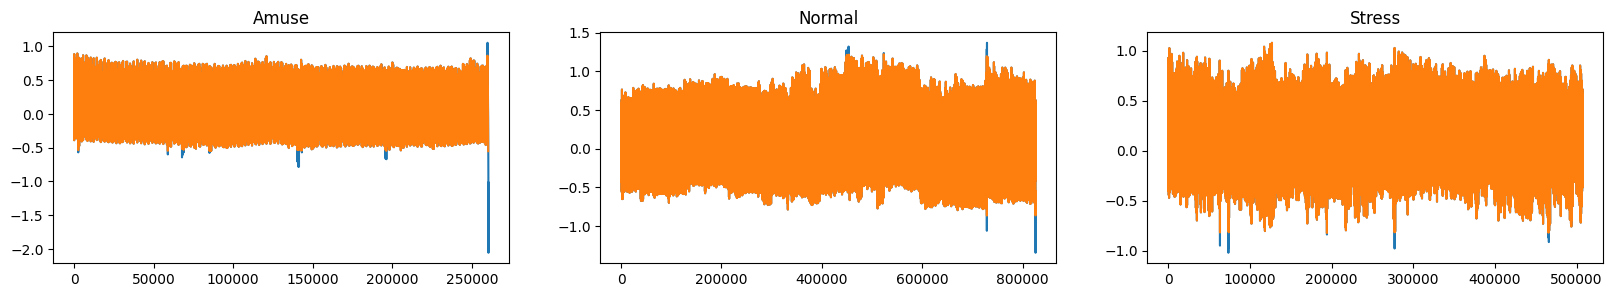

In [187]:
out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, 10, 7)
out_stress = Delet_outlier(stress_n, None, 8)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(out_amuse)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

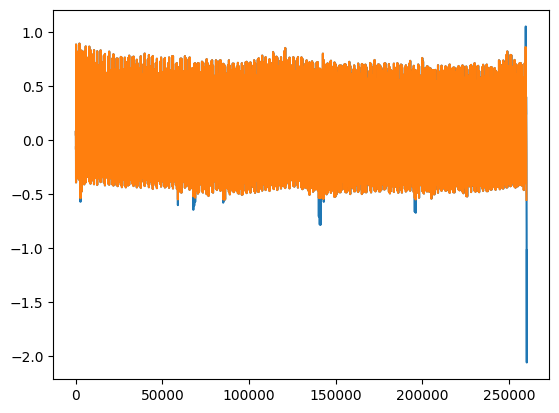

(260194, 1) (825910, 1) (507466, 1)


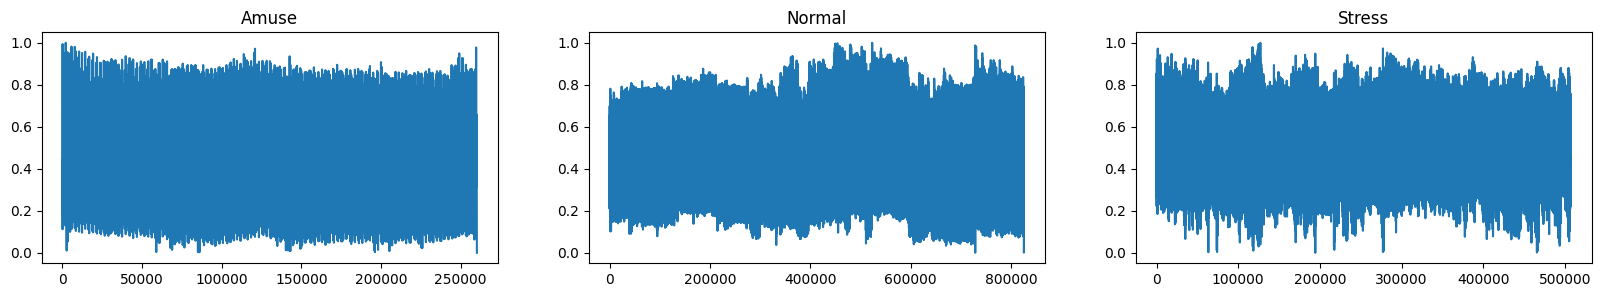

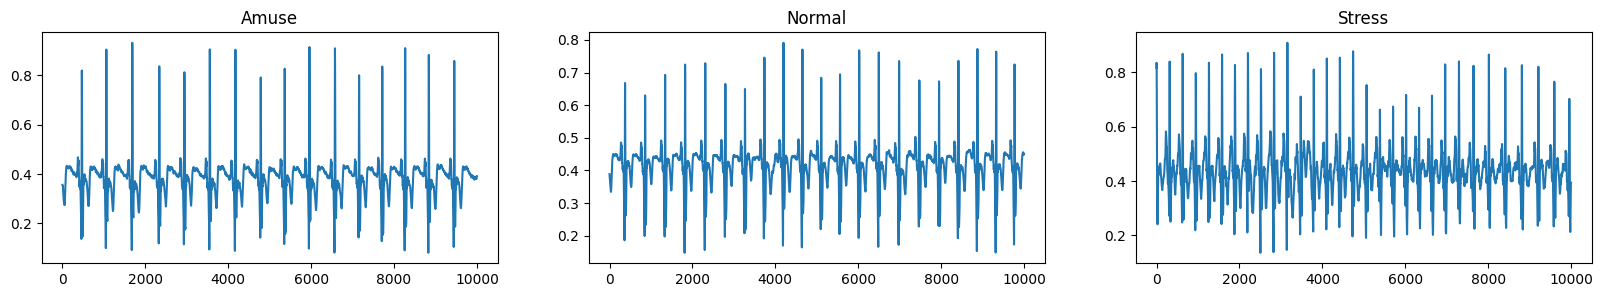

In [188]:
amuse = minmax(out_amuse)
normal = minmax(out_normal)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [189]:
name = 'S10'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S11

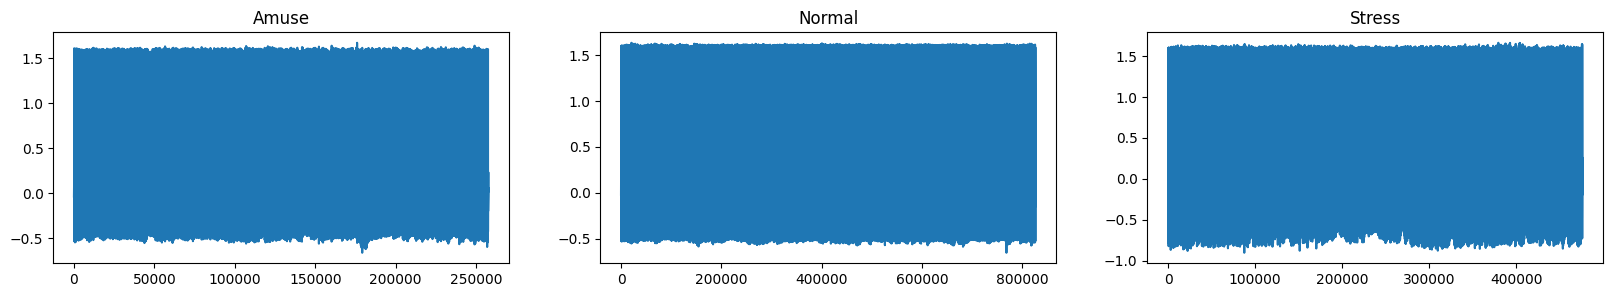

In [190]:
df = pd.read_pickle(Data + 'S11' + '/' + 'S11' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

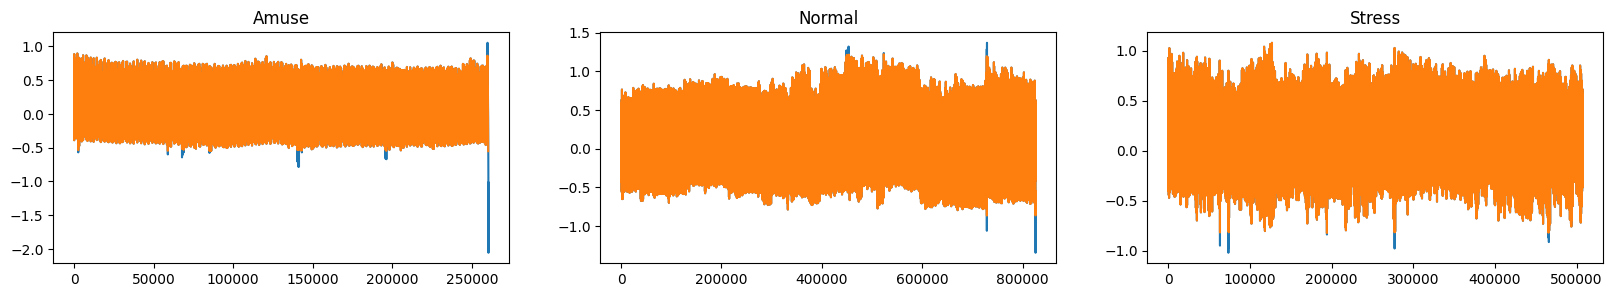

In [187]:
out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, 10, 7)
out_stress = Delet_outlier(stress_n, None, 8)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(out_amuse)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

(257600, 1) (826000, 1) (476000, 1)


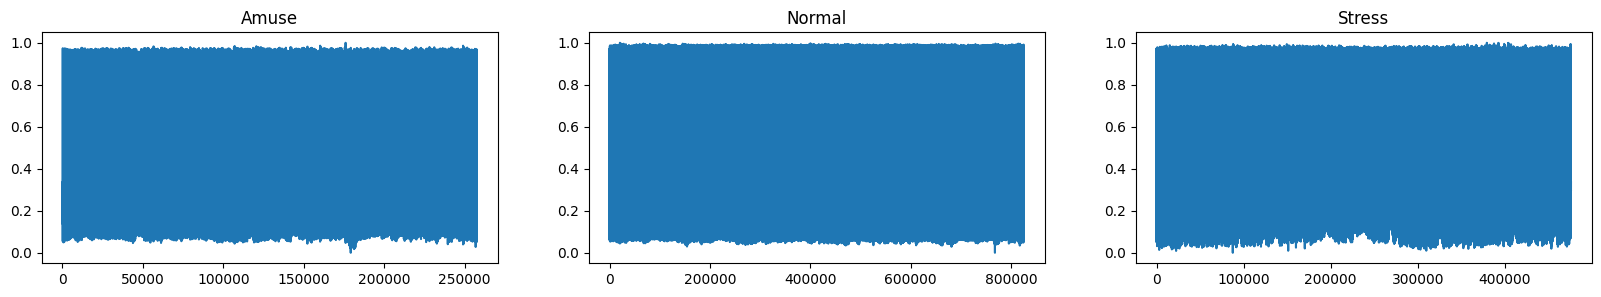

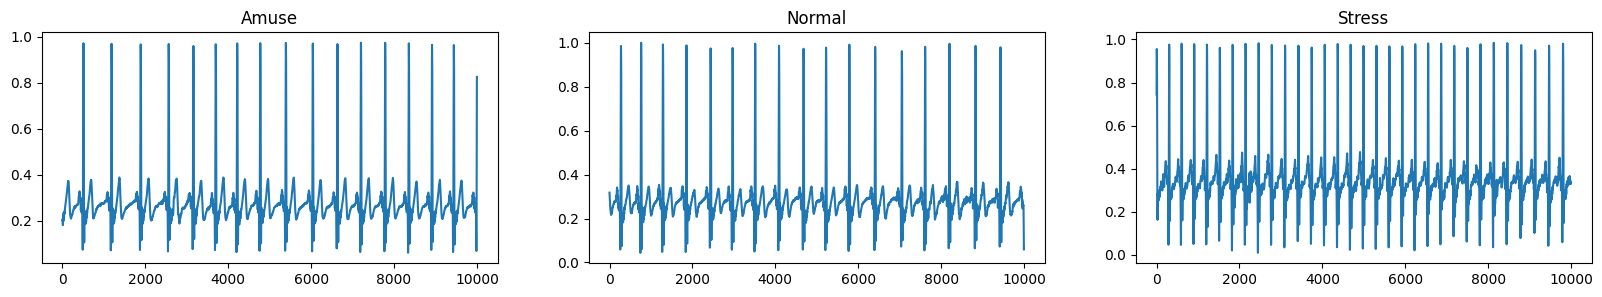

In [191]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [192]:
name = 'S11'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S13

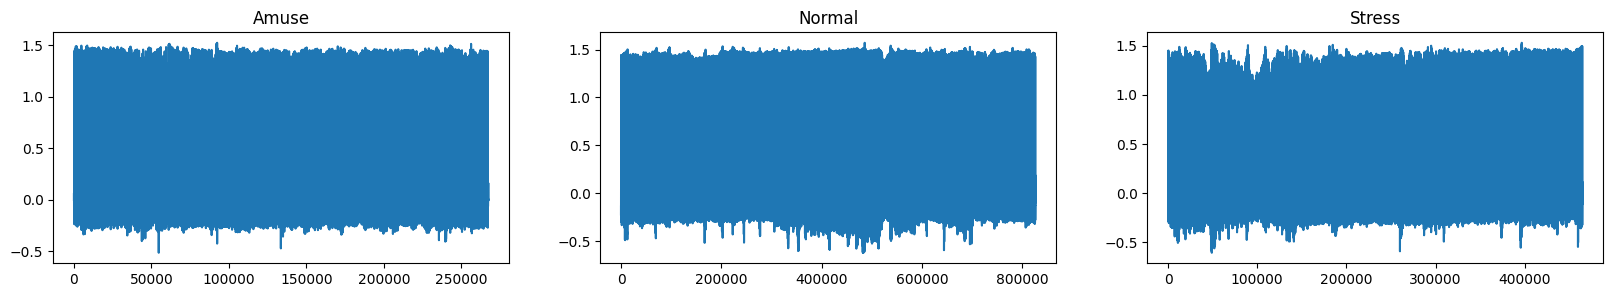

In [193]:
df = pd.read_pickle(Data + 'S13' + '/' + 'S13' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

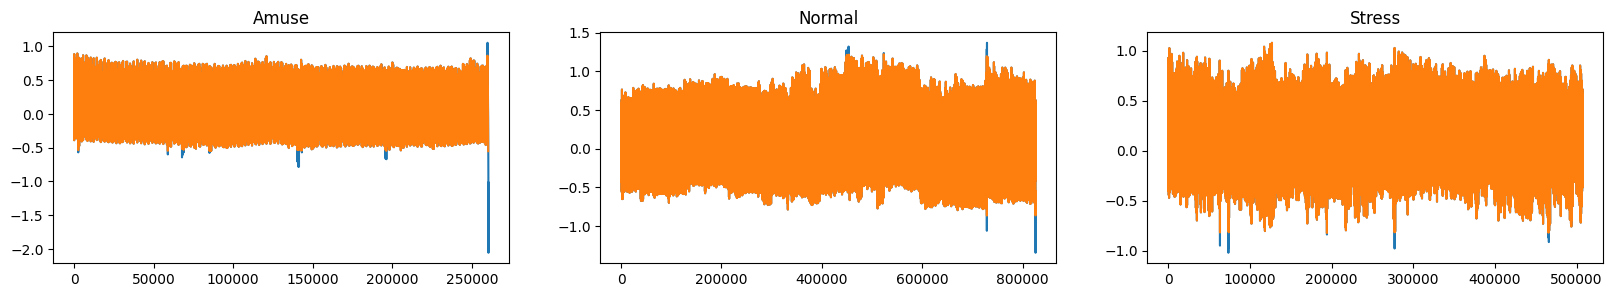

In [187]:
out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, 10, 7)
out_stress = Delet_outlier(stress_n, None, 8)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(out_amuse)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

(267400, 1) (826001, 1) (464800, 1)


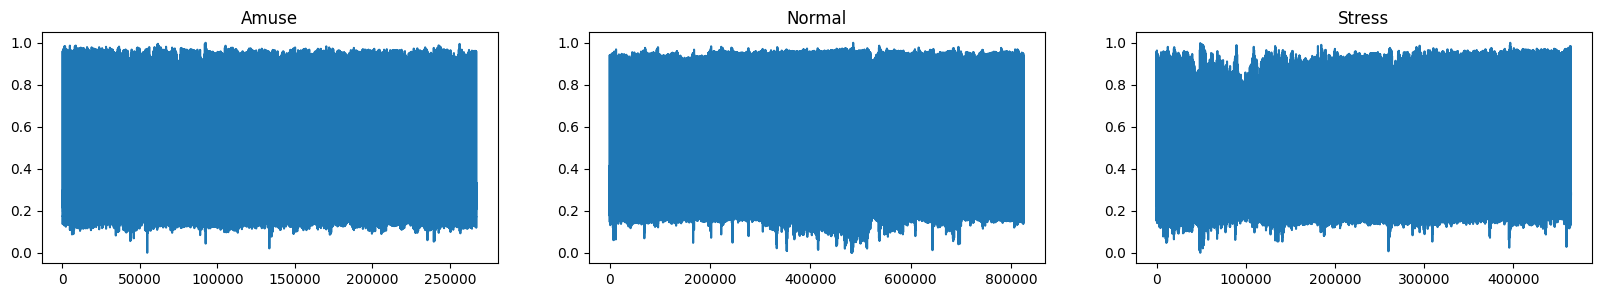

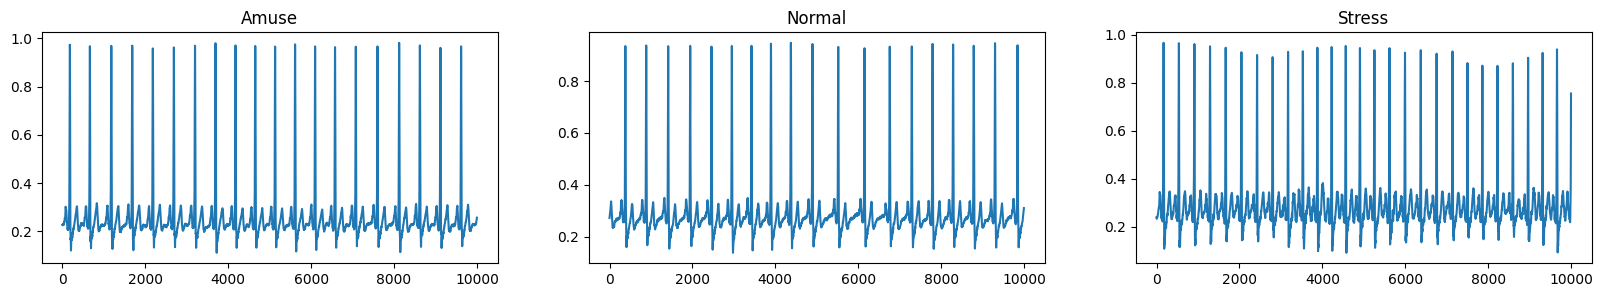

In [194]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

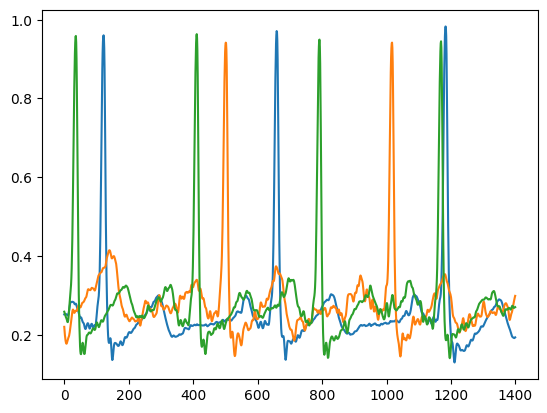

In [195]:
plt.plot(amuse[0:1400])
plt.plot(normal[0:1400])
plt.plot(stress[0:1400])

In [196]:
name = 'S13'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S14

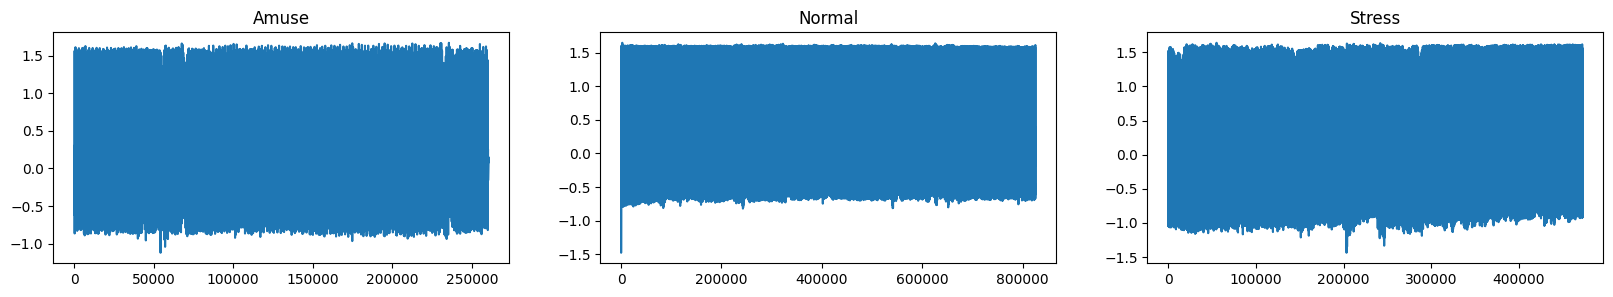

In [197]:
df = pd.read_pickle(Data + 'S14' + '/' + 'S14' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

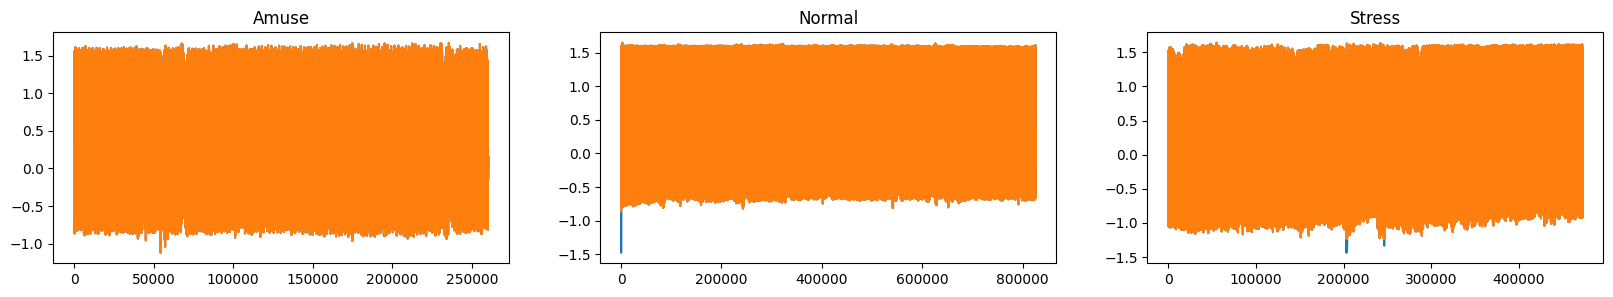

In [203]:
#out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, None, 5)
out_stress = Delet_outlier(stress_n, None, 4)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(amuse_n)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

(260401, 1) (825957, 1) (472428, 1)


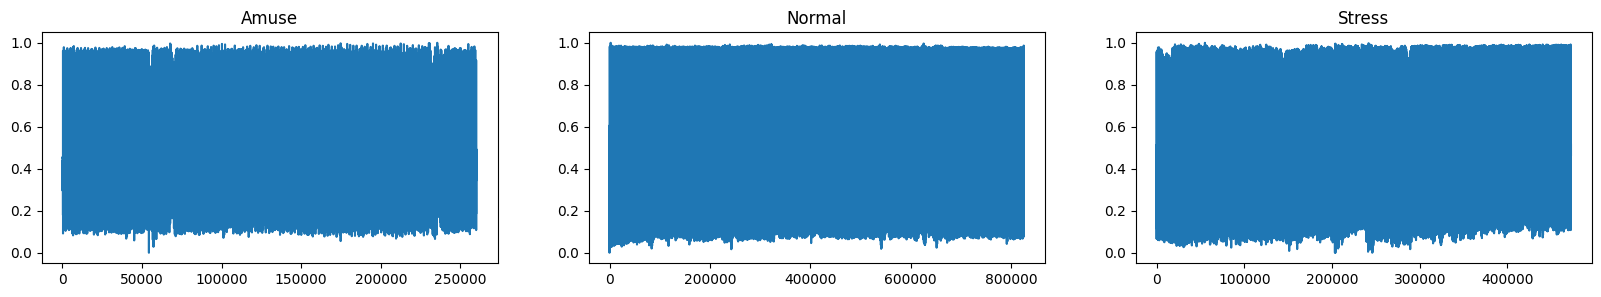

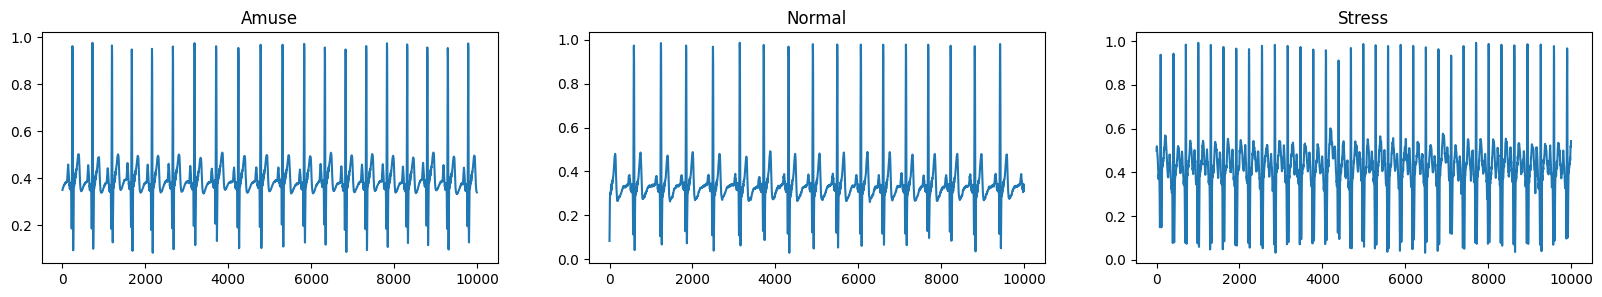

In [204]:
amuse = minmax(amuse_n)
normal = minmax(out_normal)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [205]:
name = 'S14'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S15

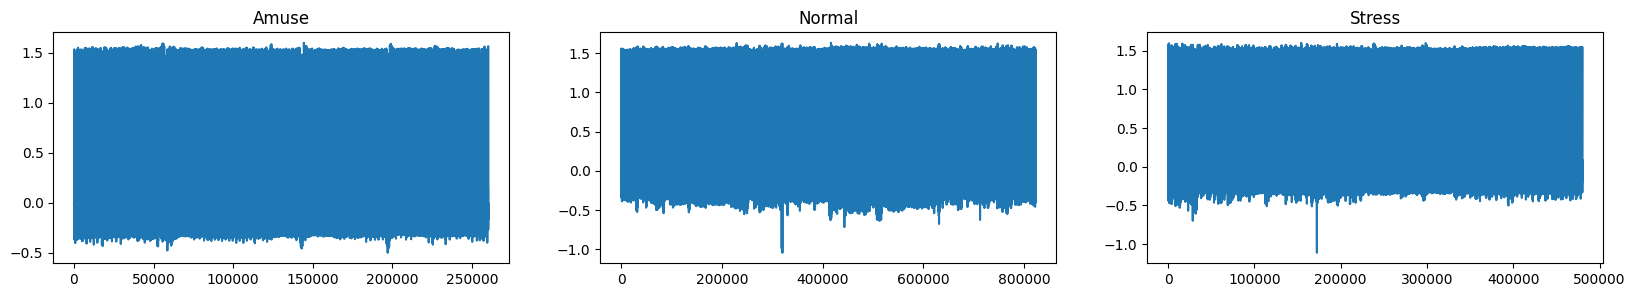

In [216]:
df = pd.read_pickle(Data + 'S15' + '/' + 'S15' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

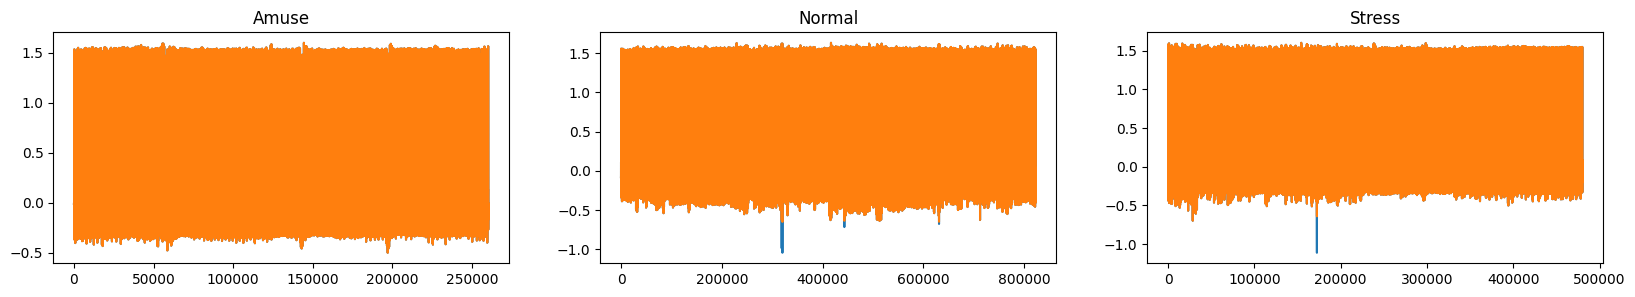

In [217]:
#out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, None, 4)
out_stress = Delet_outlier(stress_n, None, 4)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(amuse_n)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

(260400, 1) (822467, 1) (480191, 1)


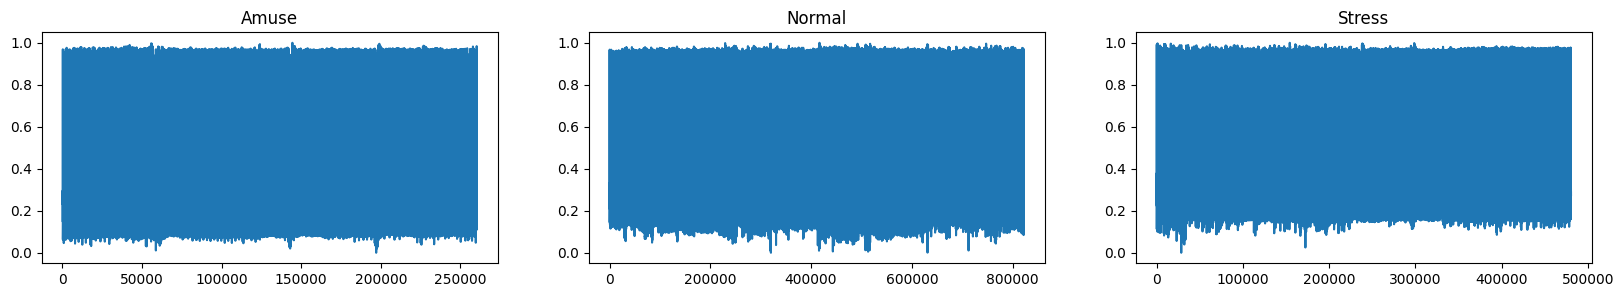

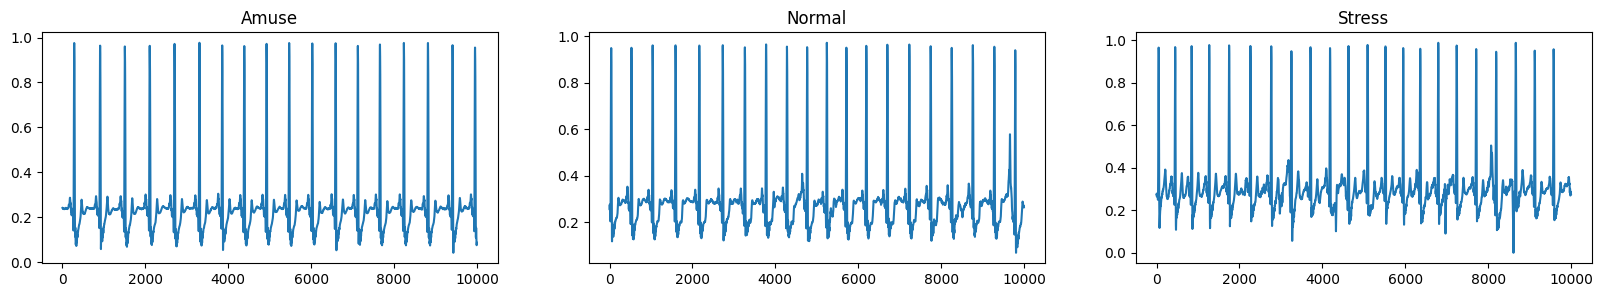

In [218]:
amuse = minmax(amuse_n)
normal = minmax(out_normal)
stress = minmax(out_stress)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [219]:
name = 'S15'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S16

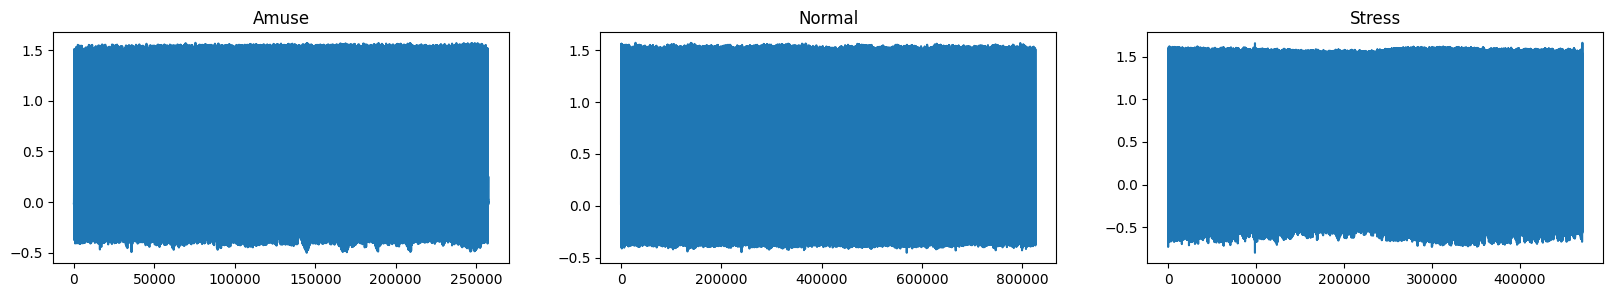

In [220]:
df = pd.read_pickle(Data + 'S16' + '/' + 'S16' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

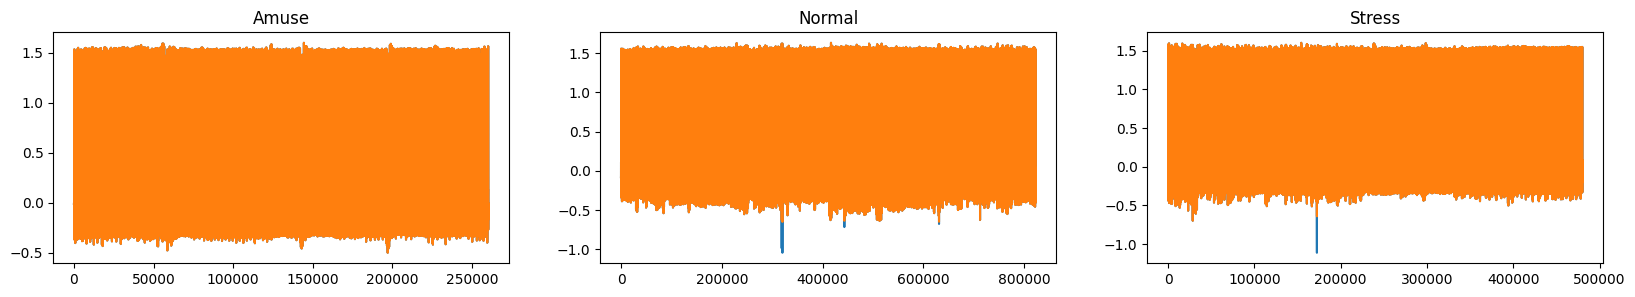

In [217]:
#out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, None, 4)
out_stress = Delet_outlier(stress_n, None, 4)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(amuse_n)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

(257600, 1) (826000, 1) (471101, 1)


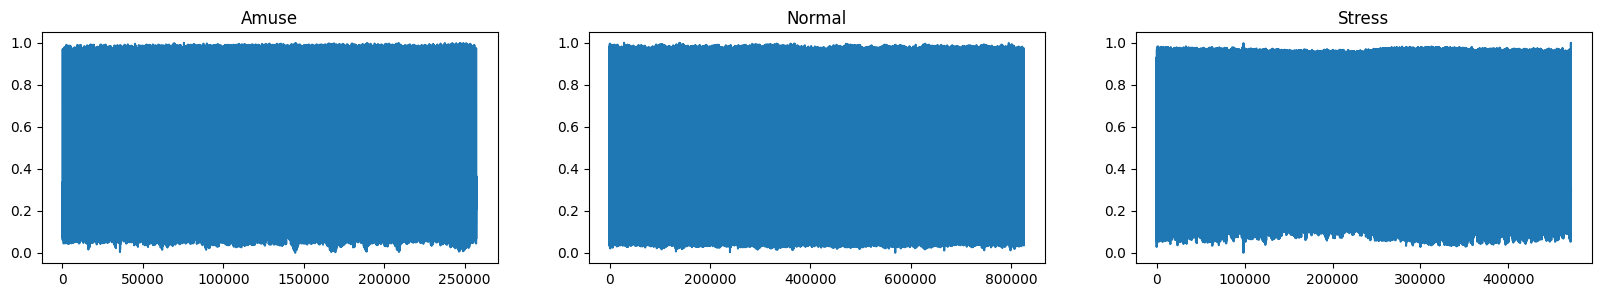

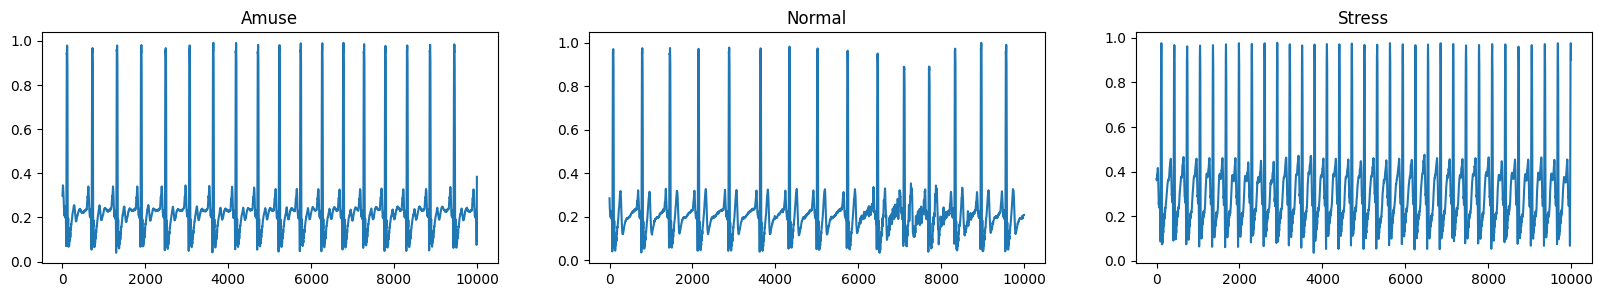

In [221]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [222]:
name = 'S16'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)

# S17

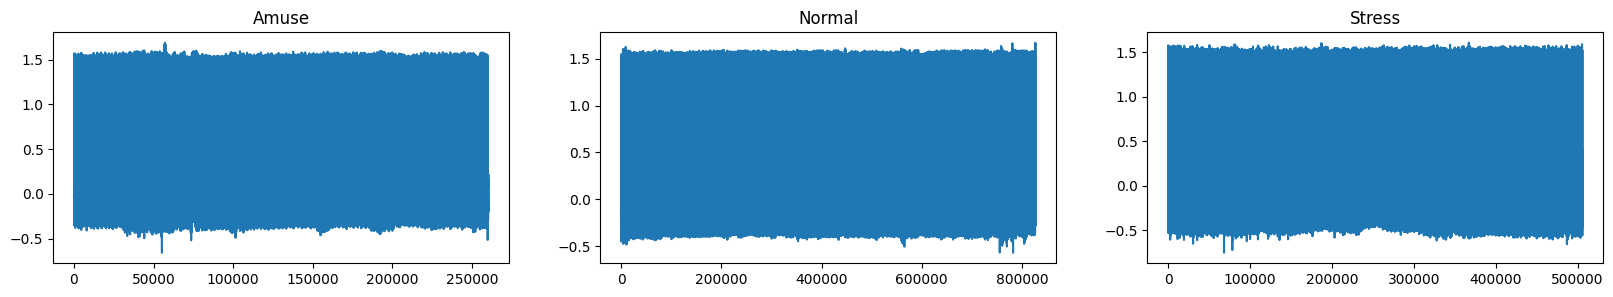

In [224]:
df = pd.read_pickle(Data + 'S17' + '/' + 'S17' + '.pkl')
ecg_v = df['signal']['chest']['ECG']
label = df['label']

amuse_ecg = ecg_v[np.where(label == 3)[0]].flatten()
normal_ecg = ecg_v[np.where(label == 1)[0]].flatten()
stress_ecg = ecg_v[np.where(label == 2)[0]].flatten()

amuse_n, normal_n, stress_n = denoise_ecg(amuse_ecg, normal_ecg, stress_ecg, high_cutoff, low_cutoff, sampling_rate, order)

plot_ecg(amuse_n, normal_n, stress_n)

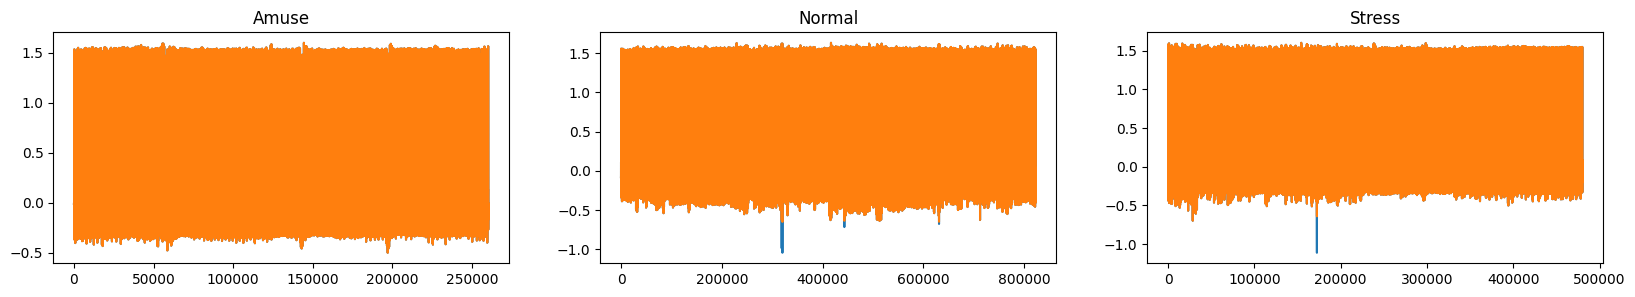

In [217]:
#out_amuse = Delet_outlier(amuse_n, 10, 6)
out_normal = Delet_outlier(normal_n, None, 4)
out_stress = Delet_outlier(stress_n, None, 4)


plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(amuse_n); plt.title('Amuse')
plt.plot(amuse_n)
plt.subplot(1,3,2)
plt.plot(normal_n); plt.title('Normal')
plt.plot(out_normal)
plt.subplot(1,3,3)
plt.plot(stress_n); plt.title('Stress')
plt.plot(out_stress)
plt.show()

(260400, 1) (826700, 1) (506100, 1)


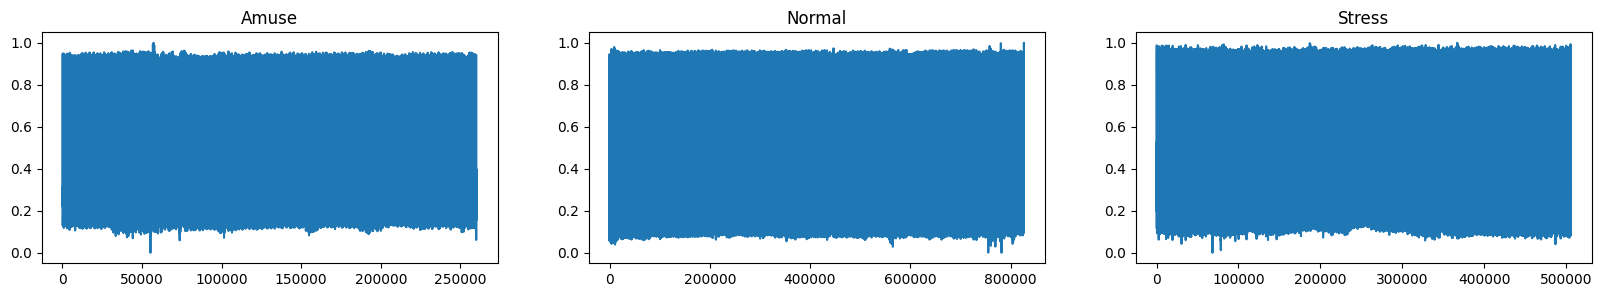

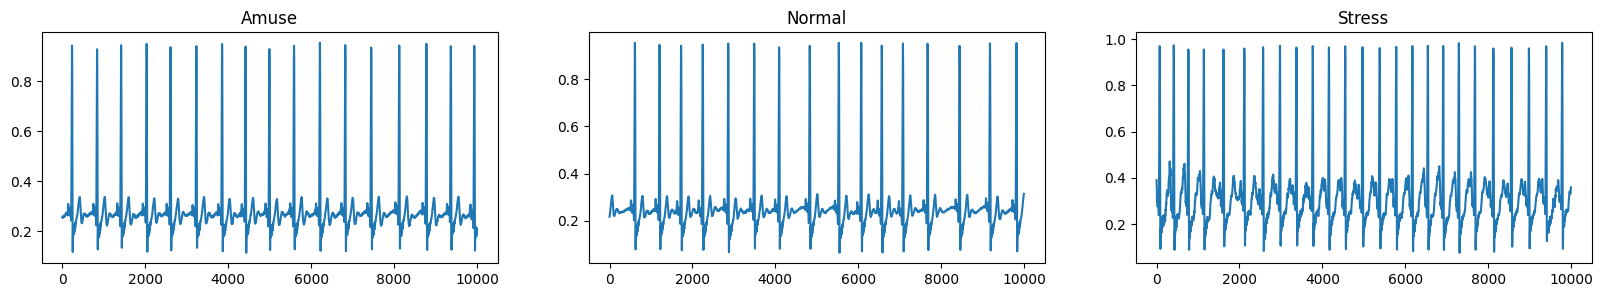

In [225]:
amuse = minmax(amuse_n)
normal = minmax(normal_n)
stress = minmax(stress_n)

print(amuse.shape, normal.shape, stress.shape)
plot_ecg(amuse, normal, stress)
plot_ecg(amuse[20000:30000], normal[20000:30000], stress[20000:30000])

In [226]:
name = 'S17'

new_data = np.concatenate([amuse, normal, stress])
new_label = np.concatenate([np.zeros(amuse.shape[0], np.int32), np.ones(normal.shape[0], np.int32), 2*np.ones(stress.shape[0], np.int32)])

data = {"signal" : new_data, "label" : new_label}

with open(save_path + name+ '.pkl','wb') as fw:
    pickle.dump(data, fw)